# WQD7005 - Data Mining
## Lab Exersice 5

#### Matrix Number : 17043640

#### Name                 : Gunasegarran Magadevan

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

In [2]:
# Read the Data
data = pd.read_csv('lab3.csv')
data.head()

,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,00601,-66.749472,18.180103,70.0,19143,9888,3.24
1,00602,-67.180247,18.363285,83.0,42042,11384,3.10
2,00603,-67.134224,18.448619,86.0,55592,10748,2.84
3,00604,-67.136995,18.498987,83.0,3844,31199,3.00
4,00606,-66.958807,18.182151,65.0,6449,9243,3.20


In [3]:
### FUNCTIONS ###
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
            
# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Text'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms

# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
''' Uses SPMF to find association rules in supplied transactions '''
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'spmf.jar', 'run', 'RuleGrowth', 'seq_rule_input.txt', 'seq_rule_output.txt', '10%', '10%'], shell=True)
    
    # read back the output rules
    outputs = open('seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence'])

In [4]:
### PRE-PROCESSING ###
def _PerpData (df):
    
    # Get the names of the columns
    _names = list(df)
    
    # loop through the data and change all null to np.nan
    for _name in _names:
        df[_name] = df[_name].replace('', np.nan)

    return df

In [5]:
### MAIN ###
data = _PerpData(data)

#### Clustering
#### K-Means

In [6]:
### KMeans ###
# take 3 variables and drop the rest
data_kmeans = data[['MedHHInc', 'MeanHHSz', 'RegDens']]

# convert df2 to matrix
X = np.asmatrix(data_kmeans)

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=rs)
#######
X = np.isnan(X)  
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)
    
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 1.919876423015796e-25
Centroid locations:
[0.00000000e+00 0.00000000e+00 1.39194212e-14]
[0. 0. 1.]
[0. 0. 0.]
Sum of intra-cluster distance: 1.919876423015796e-25
Centroid locations:
[0.00000000e+00 0.00000000e+00 1.39194212e-14]
[0. 0. 1.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.


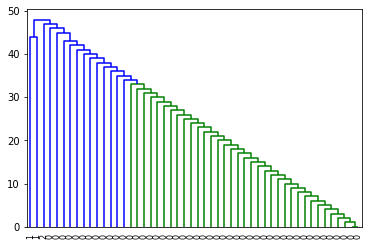

In [7]:
#Agglomerative Clustering | (Alternative to Kmeans Clustering)
agg_model = AgglomerativeClustering(n_clusters=3)
agg_model.fit(X[:50]) # subset of X, only 50 data points

plot_dendrogram(agg_model, labels=agg_model.labels_)
plt.show()

##### Understanding and Visualising a Clustering Model

/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  """Entry point for launching an IPython kernel.
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Cluster membership
2    32165
1     1013
Name: Cluster_ID, dtype: int64


/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


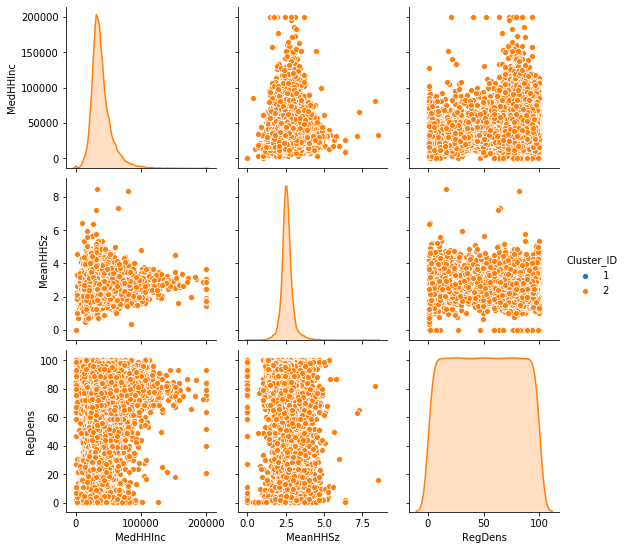

In [8]:
model = KMeans(n_clusters=3, random_state=rs).fit(X)

# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
data_kmeans['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(data_kmeans['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(data_kmeans, hue='Cluster_ID')
plt.show()

Distribution for cluster 0


/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/lib

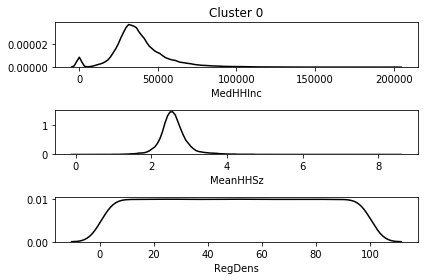

Distribution for cluster 1


/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


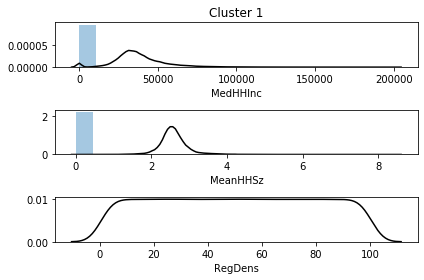

In [9]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['MedHHInc', 'MeanHHSz', 'RegDens']
n_bins = 20

# inspecting cluster 0 and 1
clusters_to_inspect = [0,1]

for cluster in clusters_to_inspect:
    # inspecting cluster 0b
    print("Distribution for cluster {}".format(cluster))

    # create subplots
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        # create the bins
        bins = np.linspace(min(data_kmeans[col]), max(data_kmeans[col]), 20)
        # plot distribution of the cluster using histogram
        sns.distplot(data_kmeans[data_kmeans['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True)
        # plot the normal distribution with a black line
        sns.distplot(data_kmeans[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

##### Determine K

/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  # This is added back by InteractiveShellApp.init_path()
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  # This is added back by InteractiveShellApp.init_path()
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  # This is added back by InteractiveShellApp.init_path()
/Users/gunasegarranmagadevan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ConvergenceWarning: Number of distinct clusters (2) found sm

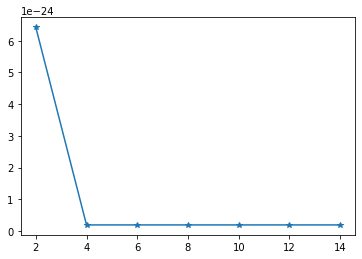

In [10]:
# Method 1: Elbow method

# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

In [11]:
#Method 2: Silhoette Score

print(clusters[1])
print("Silhouette score for k=4", silhouette_score(X, clusters[1].predict(X)))

print(clusters[2])
print("Silhouette score for k=6", silhouette_score(X, clusters[2].predict(X)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=10, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 1.0
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 1.0
